<a href="https://colab.research.google.com/github/tsangrebecca/BloomTech/blob/main/Sprint5/Module4/LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BloomTech Data Science

*Unit 2, Sprint 1, Module 4*

---

# Module Project: Logistic Regression

Do you like burritos? 🌯 You're in luck then, because in this project you'll create a model to predict whether a burrito is `'Great'`.

The dataset for this assignment comes from [Scott Cole](https://srcole.github.io/100burritos/), a San Diego-based data scientist and burrito enthusiast.

## Directions

The tasks for this project are the following:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function .
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build `model_logr` using a pipeline that includes three transfomers and `LogisticRegression` predictor. Train model on `X_train` and `X_test`.
- **Task 7:** Calculate the training and test accuracy score for your model.
- **Task 8:** Create a horizontal bar chart showing the 10 most influencial features for your  model.
- **Task 9:** Demonstrate and explain the differences between `model_lr.predict()` and `model_lr.predict_proba()`.

**Note**

You should limit yourself to the following libraries:

- `category_encoders`
- `matplotlib`
- `pandas`
- `sklearn`

In [1]:
!pip install category_encoders==2.*

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.0 MB/s eta 0:00:00


In [2]:
from category_encoders import OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split


# I. Wrangle Data

In [3]:
def wrangle(filepath):
    # Import w/ DateTimeIndex
    df = pd.read_csv(filepath,
                     parse_dates=['Date'],
                     index_col='Date')

    # Drop unrated burritos
    # it's our target so we can't have null values in the overall, so we're dropping those rows with no values
    df.dropna(subset=['overall'], inplace=True)

    # Derive binary classification target:
    # We define a 'Great' burrito as having an overall rating of 4 or higher, on a 5 point scale
    # turning a T or F statement in 0 or 1 when we cast it to integers
    df['Great'] = (df['overall'] >= 4).astype(int)

    # Drop high cardinality categoricals
    df = df.drop(columns=['Notes', 'Location', 'Address', 'URL'])

    # now that we can do that on the Beef column, we can apply this same function to the other ingredient columns with 'object' as their dtype
    # Encode binary topping columns
    binary_cols = ['Unreliable', 'NonSD', 'Beef', 'Pico',
                    'Guac', 'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp',
                    'Fish', 'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
                    'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
                    'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster', 'Egg',
                    'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini', 'Chips']
    # .apply(lambda) only works for one column, but if we want multiple columns then use .applymap(lambda)
    df[binary_cols] = df[binary_cols].applymap(lambda x: 1 if type(x)== str else 0)

    # Create pseudo one-hot encoded categories for 'burrito_type'
    burrito_type = ['california', 'asada', 'surf', 'carnitas']
    for b in burrito_type:
      df[b] = df['Burrito'].str.lower().str.contains(b).astype(int)

    # Drop columns to prevent "leakage"
    # After onehotcoding the burrito_type, we can add burrito column to the columns to be dropped:
    df = df.drop(columns=['Rec', 'overall', 'Burrito'])


    return df

filepath = "https://raw.githubusercontent.com/bloominstituteoftechnology/DS-Unit-2-Linear-Models/master/data/burritos/burritos.csv"


**Task 1:** Use the above `wrangle` function to import the `burritos.csv` file into a DataFrame named `df`.

During your exploratory data analysis, note that there are several columns whose data type is `object` but that seem to be a binary encoding. For example, `df['Beef'].head()` returns:

```
0      x
1      x
2    NaN
3      x
4      x
Name: Beef, dtype: object
```

**Task 2:** Change the `wrangle` function so that these columns are properly encoded as `0` and `1`s. Be sure your code handles upper- and lowercase `X`s, and `NaN`s.

In [ ]:
# Conduct your exploratory data analysis here
df.info()
# And modify the `wrangle` function above.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421 entries, 2016-01-18 to 2019-08-27
Data columns (total 59 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Burrito         421 non-null    object 
 1   Yelp            87 non-null     float64
 2   Google          87 non-null     float64
 3   Chips           26 non-null     object 
 4   Cost            414 non-null    float64
 5   Hunger          418 non-null    float64
 6   Mass (g)        22 non-null     float64
 7   Density (g/mL)  22 non-null     float64
 8   Length          283 non-null    float64
 9   Circum          281 non-null    float64
 10  Volume          281 non-null    float64
 11  Tortilla        421 non-null    float64
 12  Temp            401 non-null    float64
 13  Meat            407 non-null    float64
 14  Fillings        418 non-null    float64
 15  Meat:filling    412 non-null    float64
 16  Uniformity      419 non-null    float64
 17  Salsa           

In [ ]:
df['Beef'].value_counts()

x    137
X     42
Name: Beef, dtype: int64

In [ ]:
# seems like the X or x means 1, nan means 0, for has beef or no beef

In [ ]:
# let's focus on the object columns and see if there is a similar issue
df.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421 entries, 2016-01-18 to 2019-08-27
Data columns (total 39 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Burrito        421 non-null    object
 1   Chips          26 non-null     object
 2   Reviewer       420 non-null    object
 3   Unreliable     33 non-null     object
 4   NonSD          7 non-null      object
 5   Beef           179 non-null    object
 6   Pico           158 non-null    object
 7   Guac           154 non-null    object
 8   Cheese         159 non-null    object
 9   Fries          127 non-null    object
 10  Sour cream     92 non-null     object
 11  Pork           51 non-null     object
 12  Chicken        21 non-null     object
 13  Shrimp         21 non-null     object
 14  Fish           6 non-null      object
 15  Rice           36 non-null     object
 16  Beans          35 non-null     object
 17  Lettuce        11 non-null     object
 18  Tomato     

In [ ]:
df['Beef'].head(10)

Date
2016-01-18      x
2016-01-24      x
2016-01-24    NaN
2016-01-24      x
2016-01-27      x
2016-01-28    NaN
2016-01-30      x
2016-01-30    NaN
2016-02-01      x
2016-02-06      x
Name: Beef, dtype: object

In [ ]:
print(type(df['Beef'][0]), type(df['Beef'][1]), type(df['Beef'][2]), type(df['Beef'][3]), type(df['Beef'][4]), type(df['Beef'][5]))

<class 'str'> <class 'str'> <class 'float'> <class 'str'> <class 'str'> <class 'float'>


In [ ]:
# write a for loop to print out all the respective data type of each value in the first 10 rows of the 'Beef' column
for index, value in df['Beef'].head(10).items():
  print(f"Index{index} Type{type(value)}")

Index2016-01-18 00:00:00 Type<class 'str'>
Index2016-01-24 00:00:00 Type<class 'str'>
Index2016-01-24 00:00:00 Type<class 'float'>
Index2016-01-24 00:00:00 Type<class 'str'>
Index2016-01-27 00:00:00 Type<class 'str'>
Index2016-01-28 00:00:00 Type<class 'float'>
Index2016-01-30 00:00:00 Type<class 'str'>
Index2016-01-30 00:00:00 Type<class 'float'>
Index2016-02-01 00:00:00 Type<class 'str'>
Index2016-02-06 00:00:00 Type<class 'str'>


In [ ]:
# so the X and x are strings, and NaN are floats. So we wanna cast the strings as 1 and the floats as 0.
# we write a small function after .apply() and lambda x: is the arbitrary name of the function
df['Beef'].apply(lambda x: 1 if type(x)== str else 0).head(10)

Date
2016-01-18    1
2016-01-24    1
2016-01-24    0
2016-01-24    1
2016-01-27    1
2016-01-28    0
2016-01-30    1
2016-01-30    0
2016-02-01    1
2016-02-06    1
Name: Beef, dtype: int64

In [ ]:
df.select_dtypes('object').columns

Index(['Burrito', 'Chips', 'Reviewer', 'Unreliable', 'NonSD', 'Beef', 'Pico',
       'Guac', 'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp',
       'Fish', 'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
       'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
       'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster', 'Egg',
       'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini'],
      dtype='object')

In [ ]:
df['NonSD'].head(50)

Below 2 commented out code blocks are wrapped in the Wrangle function above.

In [ ]:
# # now that we can do that on the Beef column, we can apply this same function to the other ingredient columns with 'object' as their dtype
# binary_cols = ['Unreliable', 'NonSD', 'Chips', 'Beef', 'Pico',
#        'Guac', 'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp',
#        'Fish', 'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
#        'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
#        'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster', 'Egg',
#        'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini']

In [ ]:
# # .apply(lambda) only works for one column, but if we want multiple columns then use .applymap(lambda)
# df[binary_cols].applymap(lambda x: 1 if type(x)== str else 0).head(10)

,Unreliable,NonSD,Chips,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,...,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-18,0,0,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-24,0,0,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-24,0,0,0,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2016-01-24,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-27,0,0,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-28,0,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-30,0,0,0,1,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-30,0,0,0,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2016-02-01,0,0,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df = wrangle(filepath)
df['Beef'].value_counts()

0    242
1    179
Name: Beef, dtype: int64

In [ ]:
df['Cheese'].value_counts()

0    262
1    159
Name: Cheese, dtype: int64

If you explore the `'Burrito'` column of `df`, you'll notice that it's a high-cardinality categorical feature. You'll also notice that there's a lot of overlap between the categories.

**Stretch Goal:** Change the `wrangle` function above so that it engineers four new features: `'california'`, `'asada'`, `'surf'`, and `'carnitas'`. Each row should have a `1` or `0` based on the text information in the `'Burrito'` column. For example, here's how the first 5 rows of the dataset would look.

| **Burrito** | **california** | **asada** | **surf** | **carnitas** |
| :---------- | :------------: | :-------: | :------: | :----------: |
| California  |       1        |     0     |    0     |      0       |
| California  |       1        |     0     |    0     |      0       |
|  Carnitas   |       0        |     0     |    0     |      1       |
| Carne asada |       0        |     1     |    0     |      0       |
| California  |       1        |     0     |    0     |      0       |

**Note:** Be sure to also drop the `'Burrito'` once you've engineered your new features.

In [ ]:
df['Burrito'].nunique() # high cardinality stuff

132

In [ ]:
df['Burrito'].tail(10)

Date
2019-08-24       California
2019-08-27      Pollo asado
2019-08-27      Carne asada
2019-08-27        Al Pastor
2019-08-27       California
2019-08-27        Al Pastor
2019-08-27    Chile Relleno
2019-08-27       California
2019-08-27           Shrimp
2019-08-27      Pollo Asado
Name: Burrito, dtype: object

Below 2 code blocks commented out because they're wrapped in the Wrangle function

In [ ]:
# # the stretch goal just focuses on the 4 types of burrito and we have to apply onehotencoding to it
# burrito_type = ['california', 'asada', 'surf', 'carnitas']

# # df['Burrito'].str # access to the individual strings in the burrito column
# # df['Burrito'].str.lower() # to convert the strings in the column into all lower case, so that data is not case sensitive
# # df['Burrito'].str.lower().str.contains(burrito_type[0]) # to see if it contains the first item in the column which is "california", it has to be .str.contains for .contains to act on .str
# # df['Burrito'].str.lower().str.contains(burrito_type[0]).astype(int) # cast the T/F statement into int, so if it does contain "california", it'll be a 1

# # combine everything in one line and check the first 10 rows
# df['Burrito'].str.lower().str.contains(burrito_type[0]).astype(int).head(10)

# # we can also change the 'california' in burrito_type to capital C, but if there are lowercase c in the data, then we won't be able to identify it

Date
2016-01-18    1
2016-01-24    1
2016-01-24    0
2016-01-24    0
2016-01-27    1
2016-01-28    0
2016-01-30    1
2016-01-30    0
2016-02-01    1
2016-02-06    0
Name: Burrito, dtype: int64

In [ ]:
# # now we want it for the other 3 columns, so we use a for loop and iterate over the burrito_type dataframe:
# for b in burrito_type:
#   df[b] = df['Burrito'].str.lower().str.contains(b).astype(int)  # df[b] is each column in the burrito_type dataframe

# df[burrito_type].head()

,california,asada,surf,carnitas
Date,,,,
2016-01-18,1,0,0,0
2016-01-24,1,0,0,0
2016-01-24,0,0,0,1
2016-01-24,0,1,0,0
2016-01-27,1,0,0,0


In [4]:
df = wrangle(filepath)
pd.set_option('display.max_columns', None)
df.head(10)

,Neighborhood,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Reviewer,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great,california,asada,surf,carnitas
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-18,Miramar,3.5,4.2,0,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,Scott,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,1,0,0,0
2016-01-24,San Marcos,3.5,3.3,0,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,Scott,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,1,0,0,0
2016-01-24,NaN,NaN,NaN,0,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,Emily,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,1
2016-01-24,NaN,NaN,NaN,0,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,Ricardo,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,1,0,0
2016-01-27,Carlsbad,4.0,3.8,1,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,Scott,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,1,1,0,0,0
2016-01-28,NaN,NaN,NaN,0,6.99,4.0,NaN,NaN,NaN,NaN,NaN,3.0,4.0,5.0,3.5,2.5,2.5,2.5,4.0,1.0,Emily,0,0,0,0,1,1,0,1,0,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-30,Carmel Valley,3.0,2.9,0,7.19,1.5,NaN,NaN,NaN,NaN,NaN,2.0,3.0,3.0,2.0,2.5,2.5,NaN,2.0,3.0,Scott,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,1,0,0,0
2016-01-30,NaN,NaN,NaN,0,6.99,4.0,NaN,NaN,NaN,NaN,NaN,2.5,3.0,3.0,2.5,3.0,3.5,NaN,2.5,3.0,Emily,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,1
2016-02-01,UTC,3.0,3.7,1,9.25,3.5,NaN,NaN,NaN,NaN,NaN,2.0,4.5,4.5,3.5,1.5,3.0,3.5,4.0,2.0,Scott,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
df.shape

(421, 63)

# II. Split Data

**Task 3:** Split your dataset into the feature matrix `X` and the target vector `y`. You want to predict `'Great'`.

In [5]:
target = 'Great'
X = df.drop(columns=target)
y = df[target]

**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from 2016 through 2017.
- Your test set should include data from 2018 and later.

In [6]:
cutoff = '2018'
mask = X.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [7]:
# sanity check
assert len(X) == len(X_train) + len(X_test)
assert len(y) == len(y_train) + len(y_test)

In [8]:
len(y_train)

383

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [9]:
# baseline is accuracy, so we just use the counts for great and not great in the training data
y_train.value_counts(normalize=True)


0    0.582245
1    0.417755
Name: Great, dtype: float64

In [ ]:
# so if I were to predict the not great burrito, just based on the data, I would be right 58% of the time.

In [10]:
baseline_acc = y_train.value_counts(normalize=True).max()   # .max() grabs the bigger or biggest value
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5822454308093995


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_logr`, and fit it to your training data. Your pipeline should include:

- a `OneHotEncoder` transformer for categorical features,
- a `SimpleImputer` transformer to deal with missing values,
- a [`StandarScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) transfomer (which often improves performance in a logistic regression model), and
- a `LogisticRegression` predictor.

In [11]:
model_logr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression()
)

model_logr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Neighborhood', 'Reviewer'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

# IV. Check Metrics

**Task 7:** Calculate the training and test accuracy score for `model_lr`.

In [12]:
training_acc = model_logr.score(X_train, y_train)
test_acc = model_logr.score(X_test, y_test)

print('Training MAE:', training_acc)
print('Test MAE:', test_acc)

Training MAE: 0.97911227154047
Test MAE: 0.7894736842105263


In [ ]:
# model not generalizing well
# maybe we need to transform the columns? that would be a stretch goal

# V. Communicate Results

**Task 8:** Create a horizontal barchart that plots the 10 most important coefficients for `model_lr`, sorted by absolute value.

**Note:** Since you created your model using a `Pipeline`, you'll need to use the [`named_steps`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) attribute to access the coefficients in your `LogisticRegression` predictor. Be sure to look at the shape of the coefficients array before you combine it with the feature names.

In [29]:
# Create your horizontal barchart here.
coefficients = model_logr.named_steps['logisticregression'].coef_[0]
features = model_logr.named_steps['onehotencoder'].get_feature_names()[1:]
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)

print(coefficients.max())
print(coefficients)




2.318161342128519
[ 9.89053646e-02 -2.74226171e-01  1.08695011e-01  4.51232621e-01
  1.01186534e-02 -1.53646678e-01  9.70353593e-02  4.21055069e-01
  5.97735129e-01  1.62506710e-01 -6.24203974e-02 -2.76893301e-03
  2.00939676e-01 -4.92616733e-03 -4.46347012e-02  9.91935685e-02
  1.38096672e-01 -3.34841002e-01  3.98153610e-01 -7.98128384e-04
 -2.50344561e-01 -8.41517105e-02 -4.17582206e-01 -1.91570518e-01
  4.98254330e-03  2.81410915e-05  2.73594342e-01 -4.74878564e-04
 -3.94218158e-02 -2.92404110e-01 -6.75204982e-03 -5.36370040e-03
  7.27802863e-02 -5.78775901e-03  1.76358127e-02 -2.78238895e-05
 -6.10447334e-03 -2.09726828e-02 -4.90142837e-02 -5.22528763e-02
 -6.02416646e-02  6.83247654e-01 -8.07958487e-01 -1.23935827e-01
  5.59077284e-01 -6.36077780e-02 -5.11165475e-01  1.44727806e-01
  2.38878351e-01 -1.13828306e-01 -3.14068269e-01  5.60483566e-01
  9.65827241e-01  1.73749474e+00  1.80219577e+00  9.74412704e-01
 -2.33971389e-01  5.91223252e-01  2.31816134e+00 -3.87563175e-01
 -3.438

/usr/local/lib/python3.10/dist-packages/category_encoders/utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


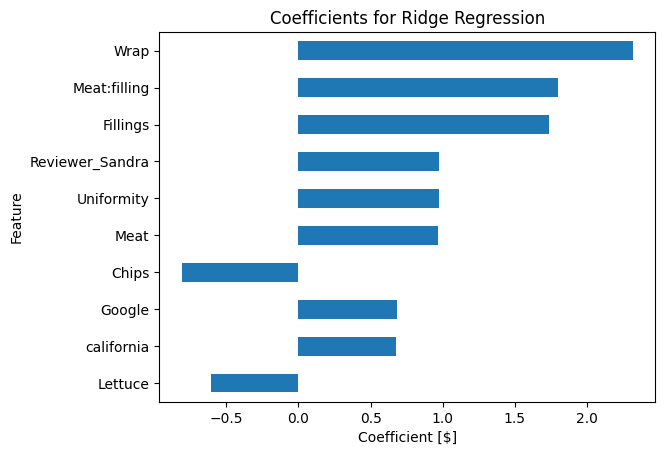

In [16]:
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Coefficient [$]')
plt.ylabel('Feature')
plt.title('Coefficients for Ridge Regression');

In [ ]:
coefficients.shape

(1, 193)

In [ ]:
features.shape

(194,)

In [ ]:
# one row with 152 columns? but we just want 152
coefficients[0].shape

(193,)

There is more than one way to generate predictions with `model_lr`. For instance, you can use [`predict`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression) or [`predict_proba`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression.predict_proba).

**Task 9:** Generate predictions for `X_test` using both `predict` and `predict_proba`. Then below, write a summary of the differences in the output for these two methods. You should answer the following questions:

- What data type do `predict` and `predict_proba` output?
- What are the shapes of their different output?
- What numerical values are in the output?
- What do those numerical values represent?

The outputs are arrays.

In [31]:
# Write code here to explore the differences between `predict` and `predict_proba`.
y_pred = model_logr.predict(X_test)
y_pred[:20] # displaying first 20 elements of list

array([1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0])

In [33]:
y_pred.shape

(38,)

y_pred predicts the outcome, with a single array, with just 0s and 1s with 0 being not great and 1 being great.

In [32]:
y_pred_prob = model_logr.predict_proba(X_test)
y_pred_prob[:20]

array([[1.41728212e-05, 9.99985827e-01],
       [8.11633328e-04, 9.99188367e-01],
       [9.92365884e-01, 7.63411603e-03],
       [9.04652267e-04, 9.99095348e-01],
       [9.98145248e-01, 1.85475187e-03],
       [8.64282347e-01, 1.35717653e-01],
       [2.50002306e-02, 9.74999769e-01],
       [8.66546053e-05, 9.99913345e-01],
       [8.49059264e-05, 9.99915094e-01],
       [6.86486712e-02, 9.31351329e-01],
       [3.12328935e-01, 6.87671065e-01],
       [9.99287222e-01, 7.12778192e-04],
       [5.48569828e-01, 4.51430172e-01],
       [3.88223738e-01, 6.11776262e-01],
       [1.51014550e-02, 9.84898545e-01],
       [1.75249140e-02, 9.82475086e-01],
       [5.33797115e-02, 9.46620289e-01],
       [9.99142563e-01, 8.57437048e-04],
       [9.93346814e-01, 6.65318591e-03],
       [9.99617590e-01, 3.82410088e-04]])

In [34]:
y_pred_prob.shape

(38, 2)

y_pred_prob has a 2D array, with each pair of numbers displaying probabilities of 0 (not great) on the left, and the probabilities of 1 (great) on the right.

**Give your written answer here:**

```


```
